<a href="https://colab.research.google.com/github/ksailesh/housing_price_project/blob/main/Linear_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read the Datasets

In [319]:
# Read df_enriched_features pickle file from google drive
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive/')

df_enriched_features_file_path = '/content/drive/MyDrive/Colab Notebooks/df_enriched_features.pkl'
df_without_enriched_features_file_path = '/content/drive/MyDrive/Colab Notebooks/df_without_enriched_features.pkl'
try:
  df_enriched_features = pd.read_pickle(df_enriched_features_file_path)
  display(df_enriched_features.dtypes)
  df_without_enriched_features = pd.read_pickle(df_without_enriched_features_file_path)
  display(df_without_enriched_features.dtypes)
  print("Successfully loaded the pickle files.")
except FileNotFoundError:
  print(f"Error: File not found at {df_enriched_features_file_path}. Please check the file path.")
  print(f"Error: File not found at {df_without_enriched_features_file_path}. Please check the file path.")
except Exception as e:
  print(f"An error occurred: {e}")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,0
longitude,float64
latitude,float64
housing_median_age,int64
total_rooms,int64
total_bedrooms,Int64
population,int64
households,int64
median_income,float64
median_house_value,int64
rooms_per_household,float64


,0
longitude,float64
latitude,float64
housing_median_age,int64
total_rooms,int64
total_bedrooms,Int64
population,int64
households,int64
median_income,float64
median_house_value,int64
ocean_proximity_INLAND,bool


Successfully loaded the pickle files.


# Check for Multicollinearity


In [320]:
# Check for Multicollinearity using VIF
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import numpy as np

df_enriched_features.loc[:, 'income_x_population'] = df_enriched_features['median_income'] * df_enriched_features['population_per_household']
df_enriched_features.loc[:, 'pop_x_bedroom_ratio'] = df_enriched_features['population_per_household'] * df_enriched_features['bedrooms_per_room']
df_enriched_features.loc[:, 'rooms_x_bedrooms'] = df_enriched_features['rooms_per_household'] * df_enriched_features['bedrooms_per_household']
df_enriched_features.loc[:, 'income_x_ocean_proximity'] = df_enriched_features['median_income'] * df_enriched_features['ocean_proximity_INLAND']
df_enriched_features.loc[:, 'ocean_x_rooms'] = df_enriched_features['ocean_proximity_NEAR OCEAN'] * df_enriched_features['rooms_per_household']
df_enriched_features.loc[:, 'ocean_x_rooms'] = df_enriched_features['ocean_proximity_NEAR OCEAN'] * df_enriched_features['rooms_per_household']

# Define the independent and dependent variables
X = df_enriched_features[[
                          'longitude', 'latitude',
                          # 'ocean_proximity_NEAR OCEAN', 'rooms_per_household', 'pop_x_bedroom_ratio',
                          # 'income_per_population',  'rooms_x_bedrooms',  'ocean_proximity_INLAND', 'income_x_population',
                          'housing_median_age', 'households', 'median_income', 'ocean_proximity_NEAR BAY', 'income_x_ocean_proximity',
                          'bedrooms_per_room', 'population_per_household', 'bedrooms_per_household', 'ocean_x_rooms'
                          ]]

# Extract the target variable and Apply Log Tranformation
y = df_enriched_features['median_house_value']
# y = np.log(df_enriched_features['median_house_value'])

# Convert object columns to numeric using pd.to_numeric
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.to_numeric(X[col], errors='coerce') # errors='coerce' will replace invalid values with NaN

# Explicitly convert all columns in X and y to numeric dtypes
X = X.astype(float) # Convert all columns in X to float
y = y.astype(float) # Convert y to float

X = X.dropna() # Drop rows with NaN values
y = y[X.index] # Align y with X after dropping rows

# Add a constant to the independent variables (intercept term)
X = sm.add_constant(X)

# Compute VIF for each feature
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_df)

# Identify and remove highly correlated predictors (e.g., VIF > 10)
high_vif_features = vif_df[vif_df["VIF"] > 16]["Feature"].tolist()

#Remove constant
if 'const' in high_vif_features:
  high_vif_features.remove('const')

print("\nHighly correlated features (VIF > 10):", high_vif_features)

# Remove the highly correlated features from X
X = X.drop(high_vif_features, axis=1)


                     Feature           VIF
0                      const  27676.798560
1                  longitude     14.596962
2                   latitude     15.311633
3         housing_median_age      1.323681
4                 households      1.160597
5              median_income      1.813561
6   ocean_proximity_NEAR BAY      1.534794
7   income_x_ocean_proximity      1.900154
8          bedrooms_per_room      1.768887
9   population_per_household      1.044964
10    bedrooms_per_household      1.134425
11             ocean_x_rooms      1.192303

Highly correlated features (VIF > 10): []


                          const  longitude  latitude  housing_median_age  \
const                       NaN        NaN       NaN                 NaN   
longitude                   NaN   1.000000 -0.924715           -0.107431   
latitude                    NaN  -0.924715  1.000000            0.010797   
housing_median_age          NaN  -0.107431  0.010797            1.000000   
households                  NaN   0.053298 -0.069557           -0.302469   
median_income               NaN  -0.012434 -0.082816           -0.122178   
ocean_proximity_NEAR BAY    NaN  -0.473610  0.357663            0.253891   
income_x_ocean_proximity    NaN  -0.040547  0.282312           -0.277081   
bedrooms_per_room           NaN   0.086031 -0.104250            0.135520   
population_per_household    NaN   0.112976 -0.108212           -0.006804   
bedrooms_per_household      NaN   0.015810  0.076513           -0.088300   
ocean_x_rooms               NaN   0.024352 -0.137945            0.017071   

           

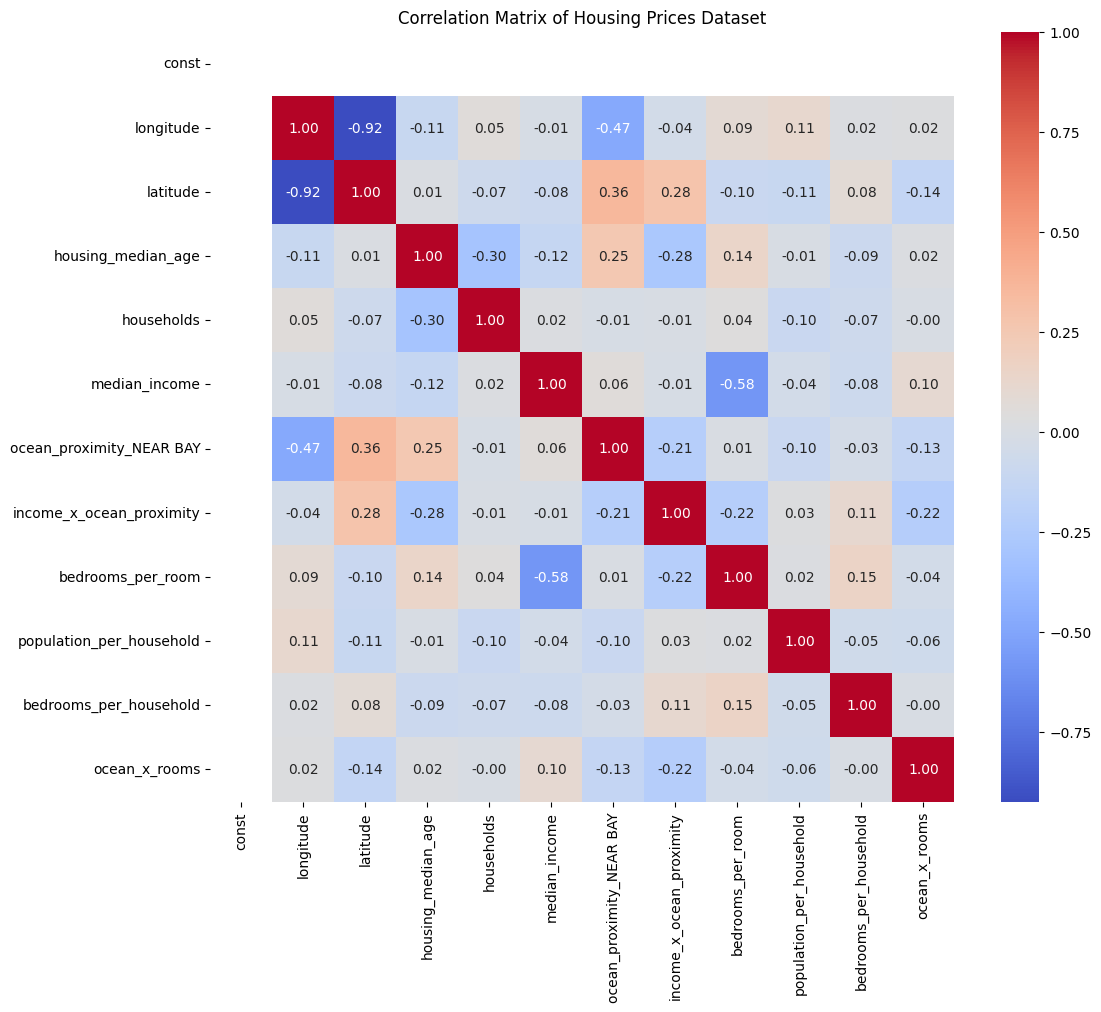

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = X.corr()
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Housing Prices Dataset')
plt.show()

# Train-Test Split, Center and Scale the Variables

In [322]:
# Train-Test Split
# Center and Scale the Variables
from sklearn.model_selection import train_test_split

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize ONLY predictors (exclude intercept)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1a. Ordinary Least Squares (OLS)

In [323]:
# Build the OLS Model
import statsmodels.api as sm

# Add intercept AFTER standardization
X_train_scaled = np.column_stack([np.ones(X_train_scaled.shape[0]), X_train_scaled])
X_test_scaled = np.column_stack([np.ones(X_test_scaled.shape[0]), X_test_scaled])
# X_train_scaled_const = sm.add_constant(X_train_scaled)
# X_test_scaled_const = sm.add_constant(X_test_scaled)

# Re-fit the OLS model after removing highly correlated predictors
ols_model = sm.OLS(y_train, X_train_scaled).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     2450.
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:30:29   Log-Likelihood:            -1.8634e+05
No. Observations:               14841   AIC:                         3.727e+05
Df Residuals:                   14829   BIC:                         3.728e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.066e+05    563.633    366.563      0.0

# 1b. Evaluate Model Performance

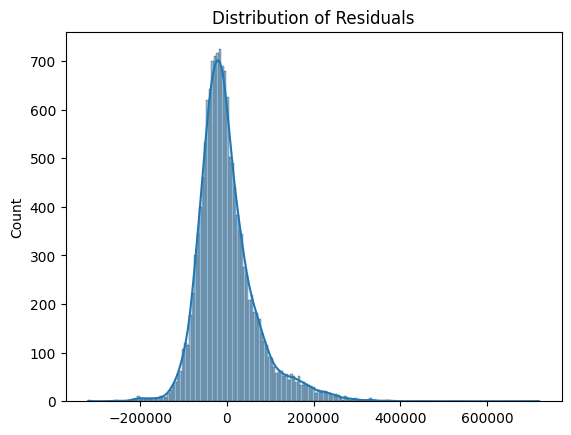

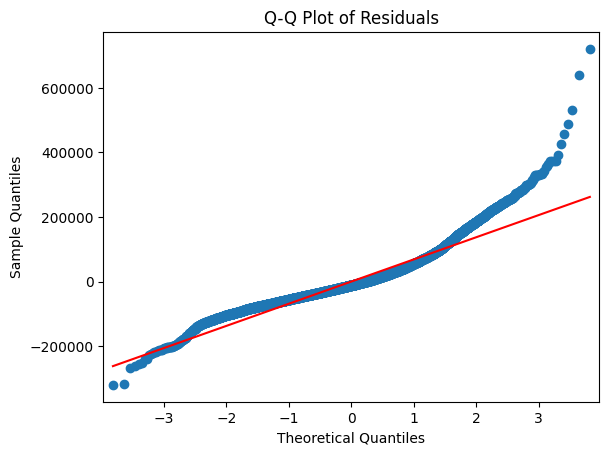

In [324]:
# Get residuals
residuals = ols_model.resid

# Histogram of residuals (should be normally distributed)
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

# Q-Q Plot (should be a straight line)
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()


In [325]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = ols_model.predict(X_test_scaled)

# Calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-squared: {r2:.4f}")



Test RMSE: 70767.10
Test R-squared: 0.6291


# 2a. Regularization techniques

In [326]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.5, l1_ratio=1)  # l1_ratio controls mix of L1 & L2
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)

# 2b. Evaluate Model Performance

In [327]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 70767.14434219635
R-squared (R²): 0.6291221153820213


# 3a. Gradien Descent


In [328]:
class BatchGradientDescent:
    def __init__(self, learning_rate=0.01, n_iterations=100):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        print(f"n_iterations: {n_iterations}")

    def fit(self, X, y):
        m = len(y)
        self.theta = np.zeros(X.shape[1])  # Initialize the weights

        for iteration in range(self.n_iterations):
            # print(f"iteration: {iteration}")
            gradients = 2/m * X.T.dot(X.dot(self.theta) - y)
            self.theta -= self.learning_rate * gradients  # Update the weights

    def predict(self, X):
        return X.dot(self.theta)  # Make predictions

# Instantiate and train Batch Gradient Descent model
bgd = BatchGradientDescent(learning_rate=0.1, n_iterations=1000)
bgd.fit(X_train_scaled, y_train)


n_iterations: 1000


In [329]:
# class StochasticGradientDescent:
#     def __init__(self, learning_rate=0.01, n_iterations=2):
#         self.learning_rate = learning_rate
#         self.n_iterations = n_iterations
#         print(f"n_iterations: {n_iterations}")

#     def fit(self, X, y):
#         m = len(y)
#         self.theta = np.zeros(X.shape[1])  # Initialize the weights


#         for iteration in range(self.n_iterations):
#             print(f"iteration: {iteration}")
#             for i in range(m):
#                 random_index = np.random.randint(m)  # Pick a random sample
#                 xi = X[random_index:random_index+1]
#                 yi = y[random_index:random_index+1]
#                 gradients = 2 * xi.T.dot(xi.dot(self.theta) - yi)
#                 self.theta -= self.learning_rate * gradients  # Update the weights

#     def predict(self, X):
#         return X.dot(self.theta)  # Make predictions

# # Instantiate and train Stochastic Gradient Descent model
# sgd = StochasticGradientDescent(learning_rate=0.1, n_iterations=50)
# sgd.fit(X_train_scaled, y_train)



In [330]:
# class MiniBatchGradientDescent:
#     def __init__(self, learning_rate=0.01, n_iterations=10, batch_size=32):
#         self.learning_rate = learning_rate
#         self.n_iterations = n_iterations
#         self.batch_size = batch_size
#         print(f"n_iterations: {n_iterations}")

#     def fit(self, X, y):
#         m = len(y)
#         self.theta = np.zeros(X.shape[1])  # Initialize the weights

#         for iteration in range(self.n_iterations):
#             print(f"iteration: {iteration}")
#             for i in range(0, m, self.batch_size):
#                 xi = X[i:i+self.batch_size]
#                 yi = y[i:i+self.batch_size]
#                 gradients = 2 / self.batch_size * xi.T.dot(xi.dot(self.theta) - yi)
#                 self.theta -= self.learning_rate * gradients  # Update the weights

#     def predict(self, X):
#         return X.dot(self.theta)  # Make predictions

# # Instantiate and train Mini-Batch Gradient Descent model
# mbgd = MiniBatchGradientDescent(learning_rate=0.1, n_iterations=10, batch_size=32)
# mbgd.fit(X_train, y_train)


# 3b. Evaluate Model Performance

In [331]:
# Evaluate the model
y_pred_bgd = bgd.predict(X_test_scaled)

y_pred_bgd = np.nan_to_num(y_pred_bgd)

# Calculate RMSE and R-squared
rmse_bgd = np.sqrt(mean_squared_error(y_test, y_pred_bgd))
r2_bgd = r2_score(y_test, y_pred_bgd)

print(f"Batch Gradient Descent RMSE: {rmse_bgd}")
print(f"Batch Gradient Descent R-squared: {r2_bgd}")


# # Evaluate the model
# y_pred_sgd = sgd.predict(X_test_scaled)

# y_pred_sgd = np.nan_to_num(y_pred_sgd)

# # Calculate RMSE and R-squared
# rmse_sgd = np.sqrt(mean_squared_error(y_test, y_pred_sgd))
# r2_sgd = r2_score(y_test, y_pred_sgd)

# print(f"Stochastic Gradient Descent RMSE: {rmse_sgd}")
# print(f"Stochastic Gradient Descent R-squared: {r2_sgd}")

# # Evaluate the model
# y_pred_mbgd = mbgd.predict(X_test)

# y_pred_mbgd = np.nan_to_num(y_pred_mbgd)

# # Calculate RMSE and R-squared
# rmse_mbgd = np.sqrt(mean_squared_error(y_test, y_pred_mbgd))
# r2_mbgd = r2_score(y_test, y_pred_mbgd)

# print(f"Mini-Batch Gradient Descent RMSE: {rmse_mbgd}")
# print(f"Mini-Batch Gradient Descent R-squared: {r2_mbgd}")

Batch Gradient Descent RMSE: 70767.41945894135
Batch Gradient Descent R-squared: 0.6291192317015877
